# Simple Inversion using the Neighbourhood Algorithm

Test the Rosenbrock Function

In [307]:
from scipy.optimize import rosen, minimize, rosen_der
import numpy as np
from pyNA import Sampler
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [308]:
def objective_function(*args):
    return rosen(args)

x = np.linspace(-1, 1, 50)

X, Y = np.meshgrid(x, x)
Z = objective_function(X, Y)

In [309]:
rosen([X,Y]).shape

(50, 50)

### 3D representation

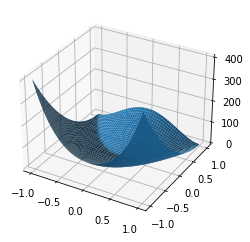

In [310]:
ax = plt.subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

plt.show()

### 2D representation

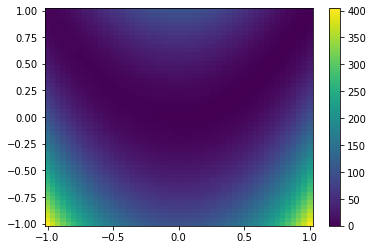

In [311]:
ax = plt.subplot(111)
im = ax.pcolormesh(X,Y,Z, shading='auto')
plt.colorbar(im)

## Minimise using scipy

In [312]:
x = [0., 0.]

res = minimize(rosen, x, tol=1e-6)

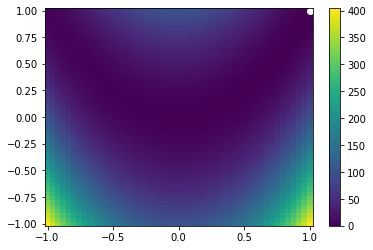

In [313]:
ax = plt.subplot(111)
im = ax.pcolormesh(X,Y,Z, shading='auto')
ax.scatter(res.x[0], res.x[1], c='w')
plt.colorbar(im)

## Minimise using NA

In [314]:
def objective_function_2D_rosen(x):
    misfits = np.empty(x.shape[0])
    for i in range(x.shape[0]):
        misfits[i] = rosen(x[i])
    return misfits

sampler = Sampler(objective_function=objective_function_2D_rosen,
                  lower_bounds=(-1.0, -1.0),
                  upper_bounds=(1.0, 1.0),
                  n_initial=100,
                  n_samples=70,
                  n_resample=10,
                  n_iterations=10)


In [315]:
sampler.generate_ensemble()

iter 0, 100 models
iter 1, 170 models
iter 2, 240 models
iter 3, 310 models
iter 4, 380 models
iter 5, 450 models
iter 6, 520 models
iter 7, 590 models
iter 8, 660 models
iter 9, 730 models


In [316]:
results = pd.DataFrame(sampler.dim_models, columns=["x", "y"])
results["misfit"] = sampler.misfits

(-1.0, 1.0)

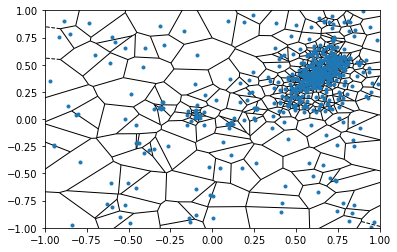

In [317]:
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
vors = Voronoi(results[["x", "y"]])
fig = voronoi_plot_2d(vors, show_vertices=False)
plt.xlim(sampler.lower_bounds[0], sampler.upper_bounds[0])
plt.ylim(sampler.lower_bounds[1], sampler.upper_bounds[1])

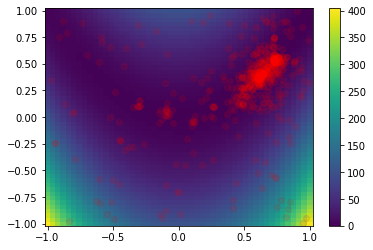

In [318]:
ax = plt.subplot(111)
im = ax.pcolormesh(X,Y,Z, shading='auto')
ax.scatter(results.x, results.y, c='r', alpha=0.1)
plt.colorbar(im)

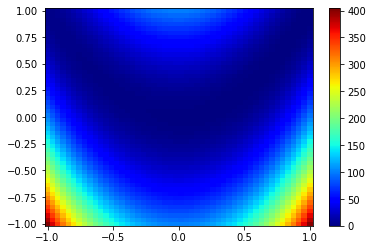

In [322]:
ax = plt.subplot(111)
im = ax.pcolormesh(X,Y,Z, shading='auto', cmap='jet')
plt.colorbar(im)

## Minimise using pyMC3

In [319]:
from scipy import optimize

In [320]:
res2 = optimize.differential_evolution(rosen, bounds=[(-1,1),(-1,1)])

In [321]:
res2

     fun: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 4803
     nit: 159
 success: True
       x: array([1., 1.])

In [338]:

def metropolis_hastings(func, x0, nsim, burnin, x_scale=(1,1), ):
    """
    MCMC algorithm using a Metropolis-Hastings sampler.
    Evaluates a Markov-Chain for starting values of
    \\( \\beta, z_t, \\Delta z, C \\) and returns the
    ensemble of model realisations.

    Args:
        nsim : int
            number of simulations
        burnin : int
            number of burn-in simulations before to nsim
        x_scale: float(4) (optional)
            scaling factor for new proposals
            (default=`[1,1,1,1]` for `[beta, zt, dz, C]`)
            - see notes
    Returns:
        X
    """
    x0 = np.array(x0)
    size = len(x_scale)
    samples = np.empty((nsim, size))


    P0 = np.exp(-func(x0) / 1000)

    # Burn-in phase
    for i in range(burnin):
        # add random perturbation
        x1 = x0 + np.random.normal(size=size) * x_scale

        # evaluate proposal probability + tempering
        P1 = np.exp(-func(x1) / 1000)

        # iterate towards MAP estimate
        if P1 > P0:
            x0 = x1
            P0 = P1

    P0 = np.exp(-func(x0))

    # Now sample posterior
    for i in range(nsim):
        # add random perturbation
        x1 = x0 + np.random.normal(size=size) * x_scale

        # evaluate proposal probability
        P0 = max(P0, 1e-99)
        P1 = np.exp(-func(x1))

        P = min(P1 / P0, 1.0)

        # randomly accept probability
        if np.random.rand() <= P:
            x0 = x1
            P0 = P1

        samples[i] = x0

    return list(samples.T)

In [354]:
xout = metropolis_hastings(rosen, (-1,-1),  1, 1000, x_scale=(1,1), )

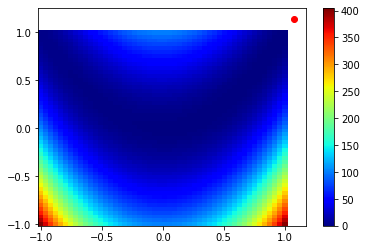

In [355]:
ax = plt.subplot(111,)
im = ax.pcolormesh(X,Y,Z, shading='auto', cmap='jet')
ax.scatter(xout[0], xout[1], c='r')
plt.colorbar(im)